In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import random
import time

import numpy as np
import pandas as pd
import seaborn as sns

import xgboost as xgb

from matplotlib import pyplot as plt
from matplotlib import style
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

style.use('seaborn-deep')

In [ ]:
folder_path = '/content/drive/MyDrive/AAIC/QQP/'

In [ ]:
N = 404290
n = 100001
skip = sorted(random.sample(list(range(1, N + 1)), N-n))
print(len(skip))

304289


In [ ]:
df = pd.read_csv(folder_path + 'final_features.csv', skiprows=skip)

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'id'], axis=1)

In [ ]:
df.shape

(100001, 795)

In [ ]:
df.head()

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.20,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,-79.721632,25.818640,-7.883405,...,-1.663620,-0.402938,-14.087219,38.538202,9.727834,13.917810,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.296450,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.568080,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,1,1,50,65,11,9,0.0,19.0,0.00,2,0,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,-62.898284,-94.979633,24.331771,...,-11.371908,-3.578342,-2.376237,20.909671,3.221330,-8.993710,-12.933957,0.584045,-15.961217,2.370193,9.618801,5.654456,-4.039893,-19.908457,-11.321396,-24.859472,-13.069850,9.953773,-1.694113,4.442514,-9.278886,-3.784161,8.152649,7.866912,8.705768,8.401290,-3.039061,10.259952,-8.754181,-7.158578,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
2,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.10,4,2,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,203.339632,-160.598199,7.764019,...,-11.345449,6.101218,-23.438455,24.105925,10.318461,-0.063605,-1.480551,6.154874,-14.630949,19.905604,2.042963,-3.555425,-1.255108,-8.036084,-9.766769,-16.191164,-8.790663,4.519232,12.908963,10.736240,-24.625240,-19.771682,7.144672,8.497629,17.803612,5.478965,-10.447376,6.479129,-2.375045,-5.082603,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689
3,0,0.000000,0.000000,0.499975,0.111110,0.111110,0.052631,0.0,0.0,10.0,14.0,40,36,36,42,0.068966,1,1,57,116,9,19,1.0,25.0,0.04,2,0,10.718371,67.524713,10.415476,100.690348,-96.828972,143.122525,-196.932471,-53.788945,142.725974,-4.295261,75.247200,-39.958403,23.582703,...,-17.810061,16.321788,-17.722231,14.557190,50.716926,-5.455423,-6.542503,24.070168,-26.473164,-0.966067,15.034271,-7.911385,-21.317372,-34.809294,-0.597576,-21.744998,-6.680073,27.754547,-2.173541,5.060243,-38.326973,-7.464106,-16.835147,-25.142457,43.419578,19.594051,-21.494349,15.263331,-23.558071,-0.953859,11.813031,26.019863,1.944268,-6.520955,23.221594,3.070264,-31.744182,19.791140,19.149179,1.436473
4,1,0.999975,0.999975,0.666644,0.499988,0.857131,0.749991,1.0,0.0,1.0,7.5,92,85,88,89,0.756757,1,2,36,39,7,8,6.0,15.0,0.40,3,1,36.289221,28.551533,52.561083,83.853943,-37.603841,36.938199,18.837557,-11.939841,48.280363,-35.661642,-40.183129,-5.280107,-11.306924,...,-4.283994,-10.119695,-13.123657,13.649252,36.551954,-10.232420,-2.185809,-0.000981,-19.262414,17.173699,7.099242,-17.222787,0.733885,-15.364829,-2.442635,-23.980326,-2.442399,11.629547,9.314315,11.338073,-15.024541,-9.276608,-0.835810,-17.640048,15.221764,21.323389,-8.826741,8.024851,4.790073,-8.033264,4.322830,22.515108,5.821354,-5.345984,1.586257,4.833842,-9.853554,11.612230,8.895851,-0.264111


### Features and Target

In [ ]:
X_features = df.drop(columns=['is_duplicate'])
y_target = df['is_duplicate']

### Converting String into Numericals

In [ ]:
cols = list(X_features.columns)
for i in cols:
    X_features[i] = X_features[i].apply(pd.to_numeric)

In [ ]:
y_target = list(map(int, y_target.values))

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, stratify=y_target, test_size=0.3)

In [ ]:
print("Number of data points in train data : ", X_train.shape)
print("Number of data points in test data : ", X_test.shape)

Number of data points in train data :  (70000, 794)
Number of data points in test data :  (30001, 794)


### Distributions of output variable in `train` and `test` data

In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ", int(train_distr[0]) / train_len, "Class 1: ", int(train_distr[1]) / train_len)

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ", int(test_distr[0]) / test_len, "Class 1: ", int(test_distr[1]) / test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6306142857142857 Class 1:  0.36938571428571426
---------- Distribution of output variable in test data ----------
Class 0:  0.6306123129229025 Class 1:  0.3693876870770974


### Confusion Matrix

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A = ( ( (C.T)/(C.sum(axis=1)) ).T )
    # divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #      [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis=1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axis=1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7],
    #                            [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3],
    #                              [3/7, 4/7]]
    # sum of row elements = 1
    
    B = (C/C.sum(axis=0))
    # divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #      [3, 4]]
    # C.sum(axis=0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix=0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6]
    #                     [3/4, 4/6]] 
    
    plt.figure(figsize=(20, 4))
    
    labels = [0, 1]
    cmap = sns.light_palette("blue")

    # representing C in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # representing B in heatmap format
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    # representing A in heatmap format
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    return None

### Building a Random Model

Log loss on Test Data using Random Model :  0.8901943485213246


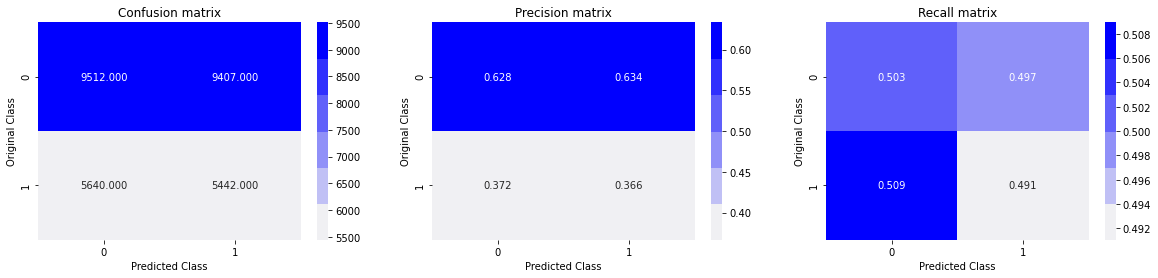

In [ ]:
rand_pred_y = np.zeros((test_len, 2))

for i in list(range(test_len)):
    rand_probs = np.random.rand(1, 2)
    prob_val = (rand_probs / sum(rand_probs[0]))[0]
    rand_pred_y[i] = prob_val

print("Log loss on Test Data using Random Model : ", log_loss(y_test, rand_pred_y, eps=1e-15))
rand_pred_y = np.argmax(rand_pred_y, axis=1)
plot_confusion_matrix(y_test, rand_pred_y)

### Building a Standard Model

In [ ]:
def build_model(X_train, X_test, y_train, y_test, loss_type, alpha_params):
    log_error_array = []
    for i in alpha_params:
        clf = SGDClassifier(alpha=i, loss=loss_type, random_state=42)

        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)

        test_i_pred_y = sig_clf.predict_proba(X_test)
        lloss = log_loss(y_test, test_i_pred_y, labels=clf.classes_, eps=1e-15)
        log_error_array.append(lloss)

        print('For values of alpha = ', i, "The log loss is : ", lloss)

    plt.figure()
    plt.plot(alpha, log_error_array, c='g')

    for i, txt in enumerate(np.round(log_error_array, 3)):
        plt.annotate((alpha_params[i], np.round(txt, 3)), (alpha_params[i], log_error_array[i]))
    
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

    best_alpha = np.argmin(log_error_array)
    clf = SGDClassifier(alpha=alpha_params[best_alpha], penalty='l2', loss=loss_type, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    train_pred_y = sig_clf.predict_proba(X_train)
    print('For values of best alpha = ', alpha_params[best_alpha], "The train log loss is : ", log_loss(y_train, train_pred_y, labels=clf.classes_, eps=1e-15))

    test_pred_y = sig_clf.predict_proba(X_test)
    print('For values of best alpha = ', alpha_params[best_alpha], "The test log loss is : ", log_loss(y_test, test_pred_y, labels=clf.classes_, eps=1e-15))

    test_pred_y = np.argmax(test_pred_y, axis=1)
    print("Total number of data points : ", len(test_pred_y))

    plot_confusion_matrix(y_test, test_pred_y)
    return None

**Logistic Regression**

For values of alpha =  1e-05 The log loss is :  0.4769120994431876
For values of alpha =  0.0001 The log loss is :  0.4469465543678218
For values of alpha =  0.001 The log loss is :  0.43825419056731457
For values of alpha =  0.01 The log loss is :  0.4517437568201926
For values of alpha =  0.1 The log loss is :  0.44779691081367823
For values of alpha =  1 The log loss is :  0.47695167269108496
For values of alpha =  10 The log loss is :  0.5180263466788809


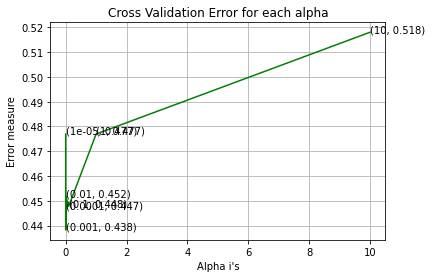

For values of best alpha =  0.001 The train log loss is :  0.43153236877483736
For values of best alpha =  0.001 The test log loss is :  0.43825419056731457
Total number of data points :  30001


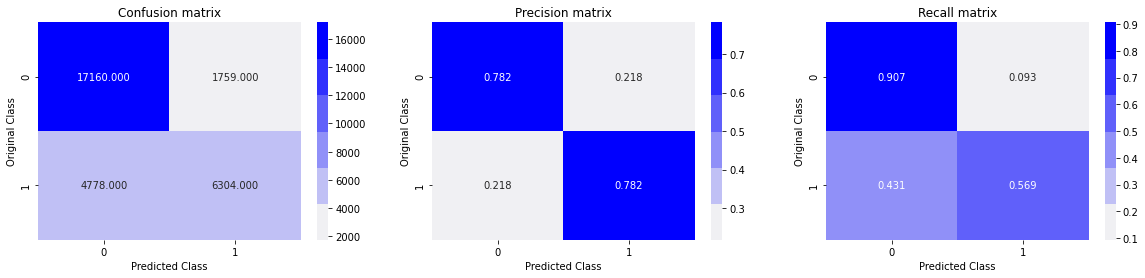

In [ ]:
# hyperparameters
alpha = [10 ** x for x in range(-5, 2)]
build_model(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, loss_type='log', alpha_params=alpha)

**Linear SVM**

For values of alpha =  1e-05 The log loss is :  0.513659830427372
For values of alpha =  0.0001 The log loss is :  0.452470599529125
For values of alpha =  0.001 The log loss is :  0.45631953595895813
For values of alpha =  0.01 The log loss is :  0.44464536314844694
For values of alpha =  0.1 The log loss is :  0.4464284198891567
For values of alpha =  1 The log loss is :  0.4751739878493823
For values of alpha =  10 The log loss is :  0.512693631233749


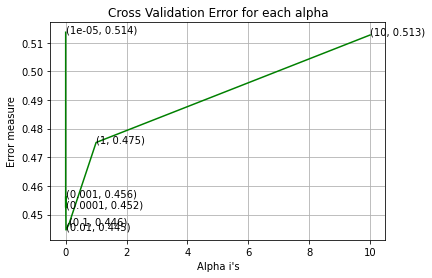

For values of best alpha =  0.01 The train log loss is :  0.4400454064322929
For values of best alpha =  0.01 The test log loss is :  0.44464536314844694
Total number of data points :  30001


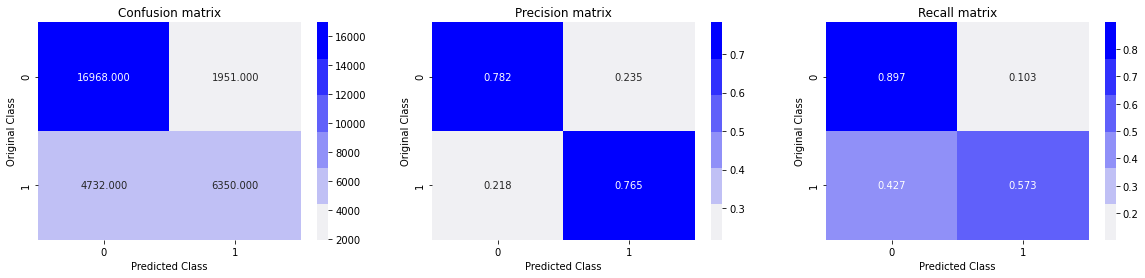

In [ ]:
# hyperparameters
alpha = [10 ** x for x in range(-5, 2)]
build_model(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, loss_type='hinge', alpha_params=alpha)

**XGBoost**

In [ ]:
def build_xgb_model(X_train, X_test, y_train, y_test, objective, eval_metric, eta, max_depth):
    params = {}

    params['objective'] = objective
    params['eval_metric'] = eval_metric
    params['eta'] = eta
    params['max_depth'] = max_depth

    d_train = xgb.DMatrix(data=X_train, label=y_train)
    d_test = xgb.DMatrix(data=X_test, label=y_test)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    bst = xgb.train(params=params, dtrain=d_train, num_boost_round=400, evals=watchlist, early_stopping_rounds=20, verbose_eval=10)

    xgdmat = xgb.DMatrix(data=X_train, label=y_train)
    preds = bst.predict(d_test)
    val_str = "The test log loss is : {}".format(log_loss(y_test, preds))

    return val_str

In [ ]:
build_xgb_model(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, objective='binary:logistic', eval_metric='logloss', eta=0.02, max_depth=4)

[0]	train-logloss:0.684892	valid-logloss:0.684931
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615925	valid-logloss:0.616313
[20]	train-logloss:0.564983	valid-logloss:0.56552
[30]	train-logloss:0.526959	valid-logloss:0.527663
[40]	train-logloss:0.497958	valid-logloss:0.498824
[50]	train-logloss:0.475395	valid-logloss:0.476438
[60]	train-logloss:0.45707	valid-logloss:0.458314
[70]	train-logloss:0.442274	valid-logloss:0.443742
[80]	train-logloss:0.430222	valid-logloss:0.43186
[90]	train-logloss:0.420584	valid-logloss:0.422462
[100]	train-logloss:0.412455	valid-logloss:0.414553
[110]	train-logloss:0.405686	valid-logloss:0.407976
[120]	train-logloss:0.400133	valid-logloss:0.402551
[130]	train-logloss:0.395345	valid-logloss:0.397911
[140]	train-logloss:0.391077	valid-logloss:0.3939
[150]	train-logloss:0.387476	valid-logloss:0.390556
[160]	train-logloss:0.384283	vali

'The test log loss is : 0.3559063042927815'

### Assignment

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.

2. Perform hyperparameter tuning  of XgBoost models using RandomsearchCV with vectorizer as TF-IDF W2V  to reduce the log-loss.